In [40]:
import os, sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models, split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [ ]:
import importlib
importlib.reload(util)
importlib.reload(models)
importlib.reload(split)

In [41]:
def get_spect_matrix_list(spects_source_dir, spects_meta_df):
    """
    Load spectrograms directly as matrices without flattening to CSV.
    
    Args:
        spects_source_dir (str): Directory where the spectrogram images are stored in .png format
        spects_meta_df (pd.DataFrame): DataFrame with columns 'filename', 'class_id', and 'author'
    
    Returns:
        tuple: (matrices_list, labels_list, authors_list)
    """
    from PIL import Image
    import numpy as np
    import os

    matrices_list = []
    labels_list = []
    authors_list = []
    
    spects_meta_df = spects_meta_df.dropna(subset=['filename', 'class_id', 'author'])

    print(f"Processing {len(spects_meta_df)} spectrograms...")
    processed_count = 0
    skipped_count = 0

    for _, row in spects_meta_df.iterrows():
        filename = row['filename']
        class_id = row['class_id']
        author = row['author']

        image_path = os.path.join(spects_source_dir, filename)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            skipped_count += 1
            continue

        img = Image.open(image_path).convert('L')  # Ensure grayscale
        
        expected_shape = (313, 224)  # PIL uses (width, height) format
        if img.size != expected_shape:
            print(f"Warning: Unexpected image size: {img.size} in file {image_path}. Expected {expected_shape}.")
            # Resize if needed
            img = img.resize(expected_shape)

        # Convert to numpy array (this gives us height x width, i.e., 313 x 224)
        pixels = np.array(img)
        
        matrices_list.append(pixels)
        labels_list.append(class_id)
        authors_list.append(author)
        processed_count += 1

    print(f"Successfully processed: {processed_count}")
    print(f"Skipped: {skipped_count}")

    if not matrices_list:
        raise ValueError("No spectrograms were loaded. Check paths and metadata consistency.")

    return matrices_list, labels_list, authors_list


In [42]:
# Load spectrogram data and metadata
spect_dir = os.path.join('..', 'database', 'spect')  # Spectrogram PNG directory
spects_df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_spects.csv'))  # Metadata

print("Loading spectrograms directly into matrices...")
matrices_list, labels_list, authors_list = get_spect_matrix_list(spect_dir, spects_df)

print(f"Loaded {len(matrices_list)} spectrograms")
print(f"Matrix shape: {matrices_list[0].shape}")
print(f"Unique labels: {len(set(labels_list))}")
print(f"Unique authors: {len(set(authors_list))}")

Loading spectrograms directly into matrices...
Processing 2387 spectrograms...
Successfully processed: 2387
Skipped: 0
Loaded 2387 spectrograms
Matrix shape: (224, 313)
Unique labels: 31
Unique authors: 75


In [43]:
# Process data for training
labels = np.array(labels_list, dtype=np.int64)
authors = np.array(authors_list)

# Convert matrices to numpy array and normalize
features = np.array(matrices_list, dtype=np.float32)
# Convert to 0-1 range first, then standardization will be applied per fold
features /= 255.0
# Reshape to add channel dimension for CNN: (samples, channels, height, width)
features = features.reshape(-1, 1, 224, 313)

print("features shape:", features.shape)
print("labels shape:", labels.shape)
print("authors shape:", authors.shape)

# Create metadata DataFrame for splitting (with sample indices)
metadata_df = pd.DataFrame({
    'sample_idx': range(len(labels)),
    'class_id': labels,
    'author': authors,
    'usable_segments': 1  # Each sample represents 1 segment
})

print("metadata_df shape:", metadata_df.shape)
print("Unique authors:", len(metadata_df['author'].unique()))
print("Unique classes:", len(metadata_df['class_id'].unique()))

features shape: (2387, 1, 313, 224)
labels shape: (2387,)
authors shape: (2387,)
metadata_df shape: (2387, 4)
Unique authors: 75
Unique classes: 31


In [44]:
# Reload modules to pick up any changes
import importlib
importlib.reload(models)
importlib.reload(util)
importlib.reload(split)

# Reload to pick up the StandardizedDataset fix and scheduler changes
from utils import util

In [45]:
# Prepare tensors for PyTorch
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

print(f"Dataset created with {len(dataset)} samples")
print(f"Tensor shapes: X={X_tensor.shape}, y={y_tensor.shape}")

Dataset created with 2387 samples
Tensor shapes: X=torch.Size([2387, 1, 313, 224]), y=torch.Size([2387])


In [46]:
# Find the best 80-20 split using author grouping
print("Finding best 80-20 split with author grouping...")
dev_df, test_df, best_split_score = split.search_best_group_seed(
    df=metadata_df,
    test_size=0.15,
    max_attempts=20_000,
    min_test_segments=3
)

# Extract indices for single fold training
train_indices_single = dev_df['sample_idx'].values
val_indices_single = test_df['sample_idx'].values

print(f"Best 80-20 split found with score: {best_split_score:.3f}")
print(f"Train samples: {len(train_indices_single)}, Validation samples: {len(val_indices_single)}")

Finding best 80-20 split with author grouping...
New best split found! Seed: 58, Score: 1.674
New best split found! Seed: 142, Score: 1.671
New best split found! Seed: 527, Score: 1.579
New best split found! Seed: 619, Score: 1.505
New best split found! Seed: 762, Score: 1.326
New best split found! Seed: 1205, Score: 1.026
New best split found! Seed: 2638, Score: 0.871

Best split found:
Seed: 2638
Stratification score: 0.871
Author overlap: set()
Segments in dev set: 1809
Segments in test set: 578
Dev segment%: 75.79%
Test segment%: 24.21%

Segment distribution comparison:
+----+------------------------+------------------------+-----------------------+-----------------------+------------------+
|    |   Target_Test_Segments |   Actual_Test_Segments |   Target_Dev_Segments |   Actual_Dev_Segments |   Total_Segments |
+====+========================+========================+=======================+=======================+==================+
|  0 |                     14 |                

## Single Fold Training with Predefined Splits

In [47]:
# Run single fold training with best 80-20 split found above
# This uses the optimal train/validation split with author grouping
train_indices, val_indices = train_indices_single, val_indices_single

single_results = util.single_fold_training_with_predefined_split(
    dataset=dataset,
    train_indices=train_indices,
    val_indices=val_indices,
    model_class=models.BirdCNN,
    num_classes=len(set(labels_list)),
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    use_class_weights=False,
    estop=35,
    standardize=True
)

Training on cuda
Dataset size: 2387
Train size: 1809, Val size: 578
Using standardization based on training data statistics
Training data statistics - Mean: 0.1540, Std: 0.1955


Training - Epoch 107/250:  43%|████▎     | 107/250 [08:05<10:49,  4.54s/epoch, best_val_loss=2.8906, lr=8.00e-06, no_improve=34, train_acc=0.426, train_f1=0.377, train_loss=1.8508, val_acc=0.215, val_f1=0.173, val_loss=3.0567]



Training Complete!
Early stopped after 108 epochs (best at epoch 73)
Final - Val Acc: 0.2163, Val Loss: 3.0406, Val F1: 0.1745
Best - Val Acc: 0.2457, Val F1: 0.1847


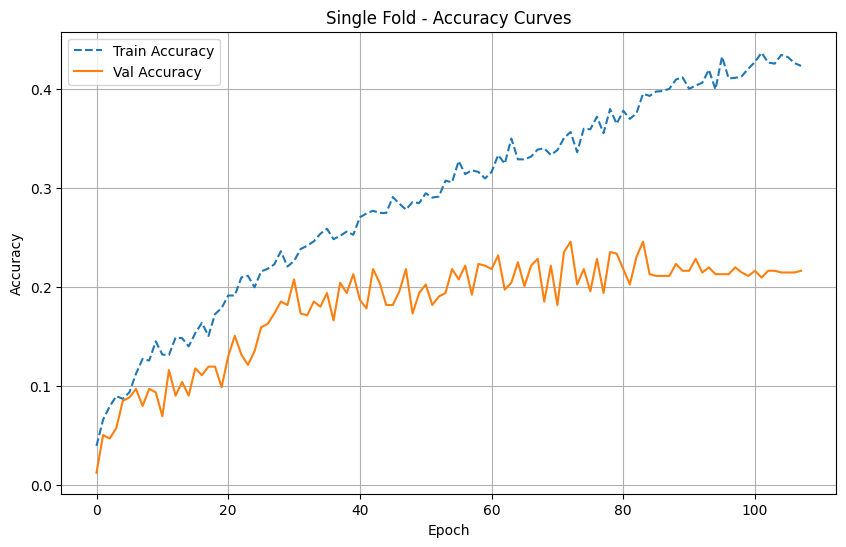

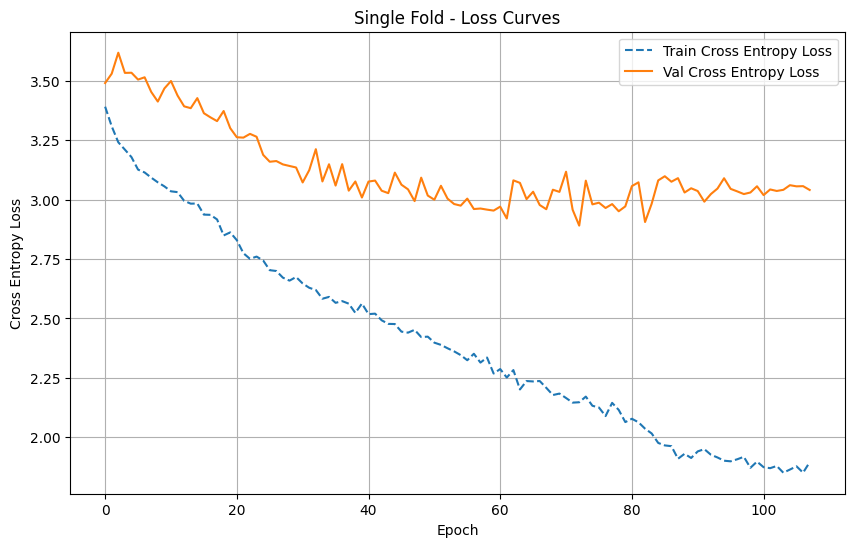

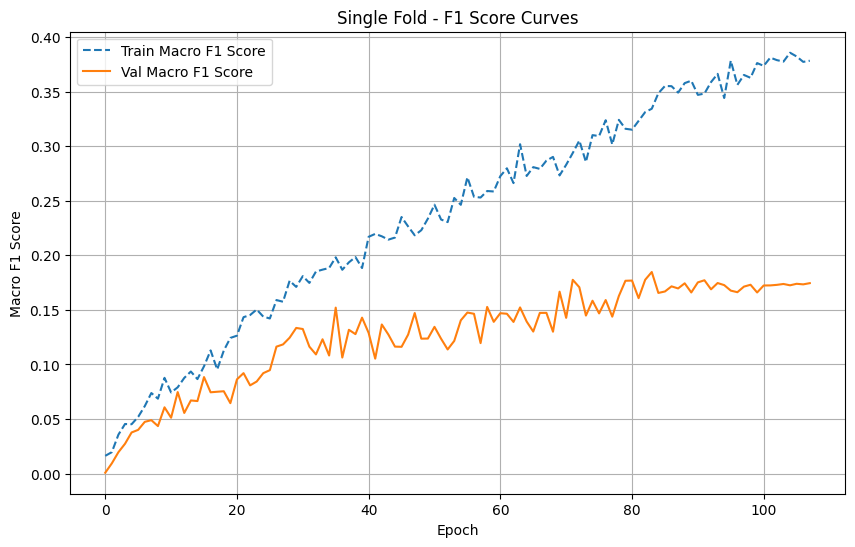

Final Validation Accuracy: 0.2163
Final Validation F1 Score: 0.1745
Best Validation Accuracy: 0.2457
Best Validation F1 Score: 0.1847


In [48]:
# Plot individual training curves for single fold
util.plot_single_fold_curve(single_results, metric_key='accuracies', title="Single Fold - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results, metric_key='losses', title="Single Fold - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results, metric_key='f1s', title="Single Fold - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results)

In [49]:
# Run single fold training with best 80-20 split found above
# This uses the optimal train/validation split with author grouping
train_indices, val_indices = train_indices_single, val_indices_single

single_results = util.single_fold_training_with_predefined_split(
    dataset=dataset,
    train_indices=train_indices,
    val_indices=val_indices,
    model_class=models.BirdResNet,
    num_classes=len(set(labels_list)),
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    use_class_weights=False,
    estop=35,
    standardize=True
)

Training on cuda
Dataset size: 2387
Train size: 1809, Val size: 578
Using standardization based on training data statistics
Training data statistics - Mean: 0.1540, Std: 0.1955


Training - Epoch 48/250:  19%|█▉        | 48/250 [02:19<09:46,  2.90s/epoch, best_val_loss=3.0085, lr=8.00e-06, no_improve=34, train_acc=0.987, train_f1=0.986, train_loss=0.1340, val_acc=0.303, val_f1=0.267, val_loss=3.2588]



Training Complete!
Early stopped after 49 epochs (best at epoch 14)
Final - Val Acc: 0.3080, Val Loss: 3.2788, Val F1: 0.2694
Best - Val Acc: 0.3166, Val F1: 0.2798


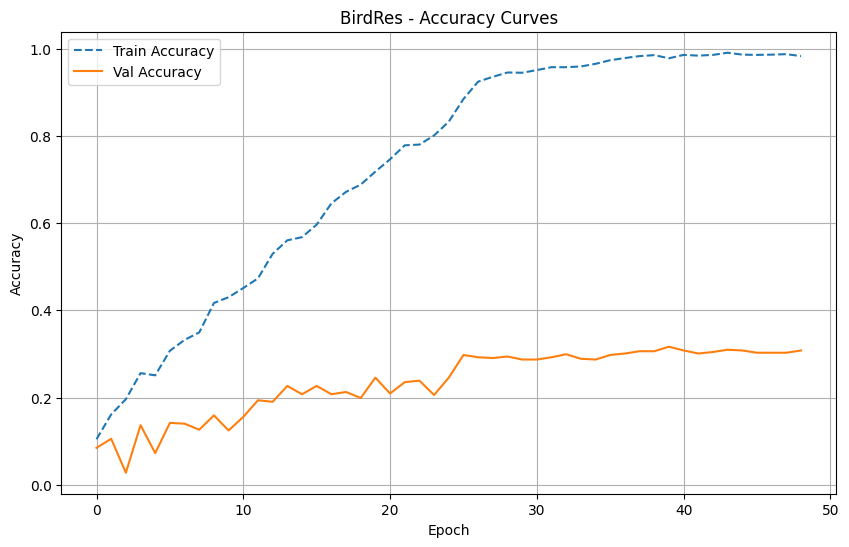

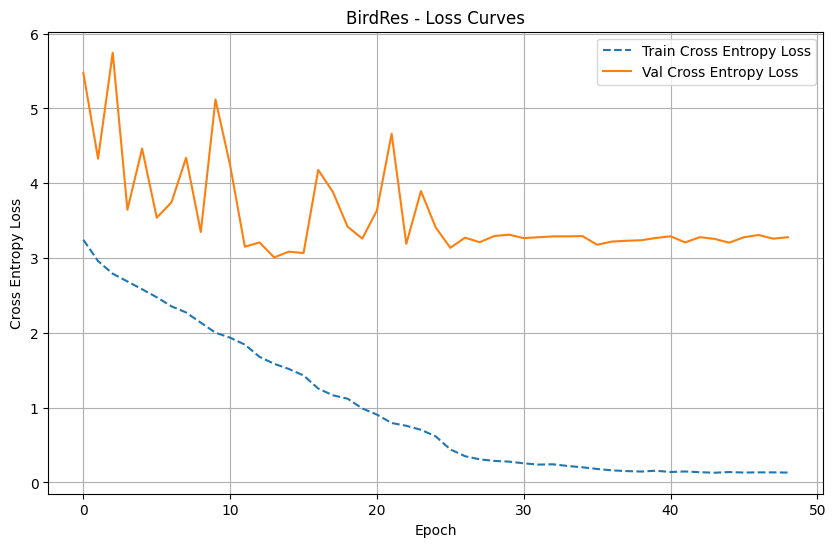

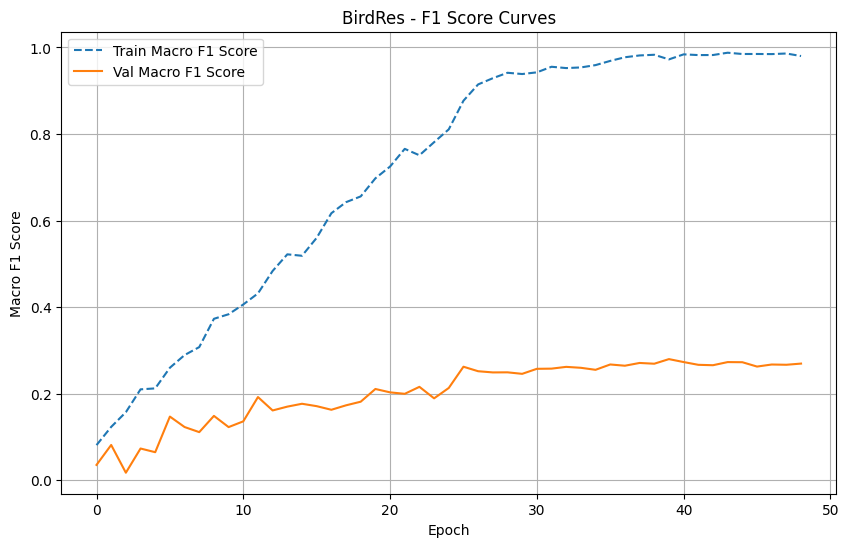

Final Validation Accuracy: 0.3080
Final Validation F1 Score: 0.2694
Best Validation Accuracy: 0.3166
Best Validation F1 Score: 0.2798


In [50]:
# Plot individual training curves for single fold
util.plot_single_fold_curve(single_results, metric_key='accuracies', title="BirdRes - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results, metric_key='losses', title="BirdRes - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results, metric_key='f1s', title="BirdRes - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results)

In [ ]:
# Run single fold training with regular 80-20 stratified split
single_results_80_20 = util.single_fold_training(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=31,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    test_size=0.2,
    random_state=435,
    use_class_weights=True,
    estop=35
)

In [ ]:
# Plot individual training curves for 80-20 split
util.plot_single_fold_curve(single_results_80_20, metric_key='accuracies', title="80-20 Split - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results_80_20, metric_key='losses', title="80-20 Split - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results_80_20, metric_key='f1s', title="80-20 Split - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results_80_20)

In [ ]:
# Run single fold training with regular 80-20 stratified split
single_results_80_20 = util.single_fold_training(
    dataset=dataset,
    model_class=models.BirdResNet,
    num_classes=31,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    test_size=0.2,
    random_state=435,
    use_class_weights=True,
    estop=35
)

In [ ]:
# Plot individual training curves for 80-20 split
util.plot_single_fold_curve(single_results_80_20, metric_key='accuracies', title="80-20 Split - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results_80_20, metric_key='losses', title="80-20 Split - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results_80_20, metric_key='f1s', title="80-20 Split - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results_80_20)